In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from ML.Classification import X_train, y_train

# Load datasets
gender = pd.read_csv('gender_submission.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

# One-hot encode Embarked column
embarked_dummies = pd.get_dummies(train.Embarked, prefix='Embarked')
train = pd.concat([train, embarked_dummies], axis=1)

# Encode Sex column (male:1, female:0)
train.Sex = train['Sex'].map({'male':1, 'female':0})

# Fill missing Age values with median
train['Age'].fillna(train['Age'].median(), inplace = True)

# Standardize Age
scaler = StandardScaler()
train.Age = scaler.fit_transform(train[['Age']])

# Create FamilySize feature
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1

# Extract title from Name
train['Title'] = train['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)

# Group rare titles under 'Rare'
train['Title'] = train['Title'].replace({
    'Mlle': 'Miss',
    'Ms': 'Miss',
    'Mme': 'Mrs',
    'Lady': 'Rare', 'the Countess': 'Rare', 'Capt': 'Rare', 'Col': 'Rare',
    'Don': 'Rare', 'Dr': 'Rare', 'Major': 'Rare', 'Rev': 'Rare',
    'Sir': 'Rare', 'Jonkheer': 'Rare', 'Dona': 'Rare'
})

# One-hot encode Title column
train = pd.get_dummies(train, columns = ['Title'], prefix = 'Title')

# Set PassengerId as index
train.set_index('PassengerId', inplace= True)

# Create IsAlone feature (1 if no family)
train['IsAlone'] = (train['FamilySize'] == 1).astype(int)

# Drop unused or redundant columns
train.drop(columns=['Ticket', 'Name', 'Cabin', 'Embarked'], inplace=True)

# Separate target and features
y = train['Survived']
X = train.drop(columns= ['Survived'])


In [164]:
# One-hot encode Embarked column
embarked_dummies_test = pd.get_dummies(test.Embarked, prefix='Embarked')
test = pd.concat([test, embarked_dummies_test], axis=1)

# Encode Sex column (male:1, female:0)
test['Sex'] = test['Sex'].map({'male': 1, 'female': 0})

# Fill missing Age with train median
test['Age'].fillna(train['Age'].median(), inplace=True)

# Standardize Age using the same scaler from train
test['Age'] = scaler.transform(test[['Age']])

# Create FamilySize
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

# Extract Title from Name
test['Title'] = test['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)

# Group rare titles
test['Title'] = test['Title'].replace({
    'Mlle': 'Miss',
    'Ms': 'Miss',
    'Mme': 'Mrs',
    'Lady': 'Rare', 'the Countess': 'Rare', 'Capt': 'Rare', 'Col': 'Rare',
    'Don': 'Rare', 'Dr': 'Rare', 'Major': 'Rare', 'Rev': 'Rare',
    'Sir': 'Rare', 'Jonkheer': 'Rare', 'Dona': 'Rare'
})

# One-hot encode Title
test = pd.get_dummies(test, columns=['Title'], prefix='Title')

# Set PassengerId as index
test.set_index('PassengerId', inplace=True)

# Create IsAlone
test['IsAlone'] = (test['FamilySize'] == 1).astype(int)

# Drop unused columns
test.drop(columns=['Ticket', 'Name', 'Cabin', 'Embarked'], inplace=True, errors='ignore')

# Align test to match train features
test = test.reindex(columns=X.columns, fill_value=0)


AttributeError: 'DataFrame' object has no attribute 'Embarked'

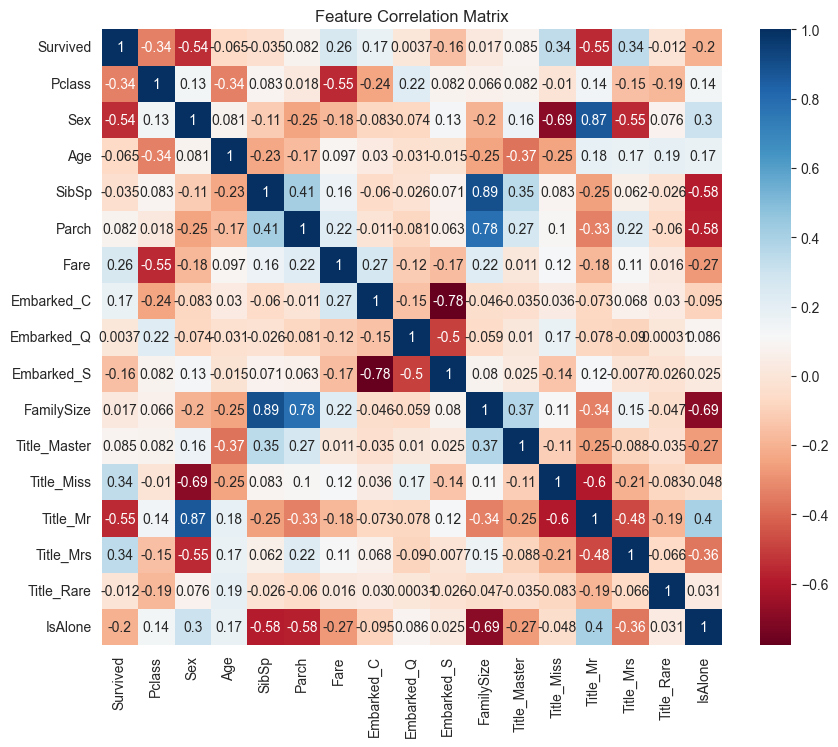

In [156]:

corr_matrix = train.corr()

plt.figure(figsize = (10, 8))
sns.heatmap(corr_matrix, cmap='RdBu', annot = True)
plt.title('Feature Correlation Matrix')
plt.show()

In [165]:

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [169]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
log_model = LogisticRegression(max_iter= 1000)
log_model.fit(X_train, y_train)
accuracy_score(log_model.predict(X_val), y_val)


0.8156424581005587

In [179]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Use classifier
rf = RandomForestClassifier()

# Same param grid (works for classifier too)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit and evaluate
random_search.fit(X_train, y_train)
y_pred = random_search.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Accuracy: 0.8212290502793296


In [181]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf':[1, 2, 4],
    'max_features':[None, 'sqrt', 'log2']
}
# Same param grid (works for classifier too)
random_search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit and evaluate
random_search.fit(X_train, y_train)
y_pred = random_search.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))




Fitting 5 folds for each of 50 candidates, totalling 250 fits
Accuracy: 0.8100558659217877


In [186]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
kn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'leaf_size': [10, 20, 30, 50],
    'weights': ['uniform', 'distance'],       # 'distance' gives closer points more weight
    'p': [1, 2]                                # 1 = Manhattan, 2 = Euclidean
}


knear_model = GridSearchCV(kn, param_grid).fit(X_train, y_train)

y_pred = knear_model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))

Accuracy: 0.8212290502793296


In [189]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
svc = SVC()
param_grid = {
    'C': [0.1, 1, 10, 100],                 # Regularization strength
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['rbf', 'linear', 'poly'],    # Kernel type
    'degree': [2, 3, 4],                    # Only used for 'poly' kernel
}
svc_model = GridSearchCV(svc, param_grid).fit(X_train, y_train)


y_pred = knear_model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))





KeyboardInterrupt: 